In [56]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.saving import register_keras_serializable
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Load data ---
yes_df = pd.read_csv("dataset/flood_yes.csv")
data = pd.read_csv("sampled_flood_data.csv")

print("✅ Enhanced dataset size:", len(data), 
      "| Flood:", data['flood_binary'].sum(), 
      "| No Flood:", (data['flood_binary'] == 0).sum())

X = data.drop("flood_binary", axis=1).astype("float32")
y = data["flood_binary"].astype("float32")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# --- Custom Layers ---
@register_keras_serializable()
def rainfall_proximity_penalty(inputs):
    rainfall = inputs[:, 0]
    distance = inputs[:, 4]
    proximity_score = tf.sigmoid((150 - distance) * 0.04)
    rainfall_score = tf.sigmoid((rainfall - 90) * 0.3)
    return (rainfall_score * proximity_score)[:, None]

@register_keras_serializable()
def flood_risk_booster(inputs):
    slope = inputs[:, 3]
    rainfall = inputs[:, 0]
    slope_boost = tf.sigmoid((slope - 2.0) * 1.5)
    rain_boost = tf.sigmoid((rainfall - 60) * 0.25)
    return (1.0 + 0.25 * slope_boost * rain_boost)[:, None]

@register_keras_serializable()
def flood_suppression_mask(inputs):
    elevation = inputs[:, 2]
    rainfall = inputs[:, 0]
    flatness = tf.sigmoid((elevation - 9.0) * 0.6)
    dryness = tf.sigmoid((20.0 - rainfall) * 0.2)
    return (1.0 - 0.3 * flatness * dryness)[:, None]

class PrintValidationStats(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.validation_data[0])
        print(f"Epoch {epoch+1} raw preds (first 5):", preds[:5].flatten())

# Then pass it into `callbacks=[early_stop, PrintValidationStats()]`

# --- Model Architecture (FireNet Style) ---
input_layer = layers.Input(shape=(5,))
x = layers.BatchNormalization()(input_layer)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
logits = layers.Dense(1)(x)

penalty = layers.Lambda(rainfall_proximity_penalty, output_shape=(1,))(input_layer)
booster = layers.Lambda(flood_risk_booster, output_shape=(1,))(input_layer)
suppressor = layers.Lambda(flood_suppression_mask, output_shape=(1,))(input_layer)

modulated_logits = layers.Add()([
    logits,
    layers.Multiply()([penalty, booster, suppressor])
])
adjusted_output = layers.Activation("sigmoid")(modulated_logits)


model = models.Model(inputs=input_layer, outputs=adjusted_output)
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.05)
, metrics=["accuracy"])

# --- Train & Evaluate ---
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, callbacks=[early_stop])

loss, acc = model.evaluate(X_test, y_test)
print(f"🌊 FloodNet Accuracy: {acc:.4f}")
model.save("models/floodnet_model.h5")


✅ Enhanced dataset size: 2000 | Flood: 1000 | No Flood: 1000
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9954 - loss: 0.2282 - val_accuracy: 1.0000 - val_loss: 0.1240
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 0.1300 - val_accuracy: 1.0000 - val_loss: 0.1219
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.1594 - val_accuracy: 1.0000 - val_loss: 0.1198
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.1282 - val_accuracy: 1.0000 - val_loss: 0.1196
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.1252 - val_accuracy: 1.0000 - val_loss: 0.1255
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9875 - loss: 0.1467 - val_accuracy: 1.0000 - val_loss: 0.1182
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9982 - loss: 0.1268 - val_accuracy: 1.0000 - val_loss: 0.1186
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 

🌊 FloodNet Accuracy: 1.0000


In [57]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

print("Sklearn Accuracy:", accuracy_score(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))
print(model.predict(X_test[:5]))

sample = np.array([[40, 1000, 10, 5, 300]], dtype=np.float32)
print(model.predict(sample))

print(np.round(model.predict(X_test[:10]), 4).flatten())



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Sklearn Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       300
         1.0       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
[[0.022702  ]
 [0.03267875]
 [0.01895293]
 [0.9793537 ]
 [0.02165876]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[0.02631075]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[0.0227 0.0327 0.019  0.9794 0.0217 0.9746 0.0217 0.9627 0.0219 0.9756]


In [26]:
import numpy as np
import pandas as pd

# Set random seed
np.random.seed(42)

# Define number of samples per class
n_flood = 2500
n_no_flood = 2500

features = []
labels = []

def generate_sample():
    rainfall = np.random.gamma(shape=2.0, scale=20.0)
    river_level = np.random.normal(loc=3.0, scale=1.0)
    soil_moisture = np.random.beta(a=2.0, b=5.0) * 100
    temperature_C = np.random.normal(loc=25.0, scale=5.0)
    wind_speed_kmh = np.random.exponential(scale=10.0)

    # Clip to physical bounds
    river_level = np.clip(river_level, 0, 10)
    soil_moisture = np.clip(soil_moisture, 0, 100)
    temperature_C = np.clip(temperature_C, -10, 50)
    wind_speed_kmh = np.clip(wind_speed_kmh, 0, 100)

    # Convert to proper units
    temperature_K = temperature_C + 273.15
    wind_speed_mps = wind_speed_kmh / 3.6

    # Compute risk score (logistic-like model with noise)
    risk = (
        0.03 * rainfall +
        0.6 * (river_level > 5) +
        0.4 * (soil_moisture > 70) +
        0.2 * (temperature_K < 283.15)
    )
    flood_prob = 1 / (1 + np.exp(-risk + np.random.normal(0, 0.5)))
    flood = int(flood_prob > 0.5)

    return [rainfall, river_level, soil_moisture, temperature_K, wind_speed_mps], flood

# Balanced generation loop
flood_count = 0
no_flood_count = 0

while flood_count < n_flood or no_flood_count < n_no_flood:
    x, y = generate_sample()
    if y == 1 and flood_count < n_flood:
        features.append(x)
        labels.append(1)
        flood_count += 1
    elif y == 0 and no_flood_count < n_no_flood:
        features.append(x)
        labels.append(0)
        no_flood_count += 1

# Create DataFrame
df = pd.DataFrame(features, columns=[
    "rainfall_mm", "river_level_m", "soil_moisture_pct", "temperature_K", "wind_speed_mps"
])
df["flood_occurred"] = labels

# Save to CSV
df.to_csv("synthetic_flood_data.csv", index=False)

# Output balance
print(df["flood_occurred"].value_counts())
print("✅ Dataset saved as synthetic_flood_data.csv")


flood_occurred
1    2500
0    2500
Name: count, dtype: int64
✅ Dataset saved as synthetic_flood_data.csv


📊 Summary Statistics:
        rainfall_mm  river_level_m  soil_moisture_pct  temperature_K  \
count  5000.000000    5000.000000        5000.000000    5000.000000   
mean     27.747435       2.969646          28.215636     298.092082   
std      24.583808       0.967198          15.768772       5.039576   
min       0.092466       0.000000           0.519050     280.445194   
25%      11.210576       2.317494          15.966864     294.708963   
50%      19.685111       2.987464          26.255259     298.047996   
75%      36.267353       3.649107          38.334486     301.476684   
max     192.145864       6.852731          87.980497     315.870325   

       wind_speed_mps  flood_occurred  
count     5000.000000      5000.00000  
mean         2.783606         0.50000  
std          2.751734         0.50005  
min          0.000348         0.00000  
25%          0.834820         0.00000  
50%          1.965147         0.50000  
75%          3.881205         1.00000  
max         20.89

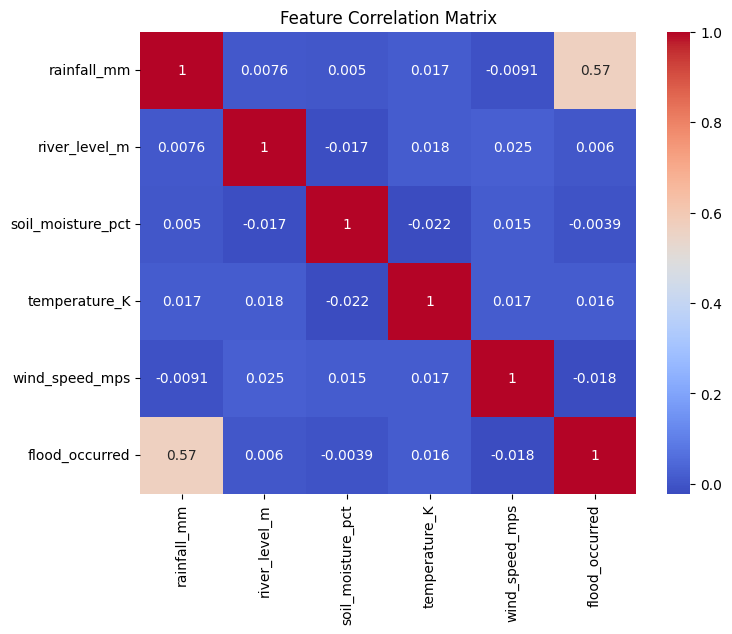

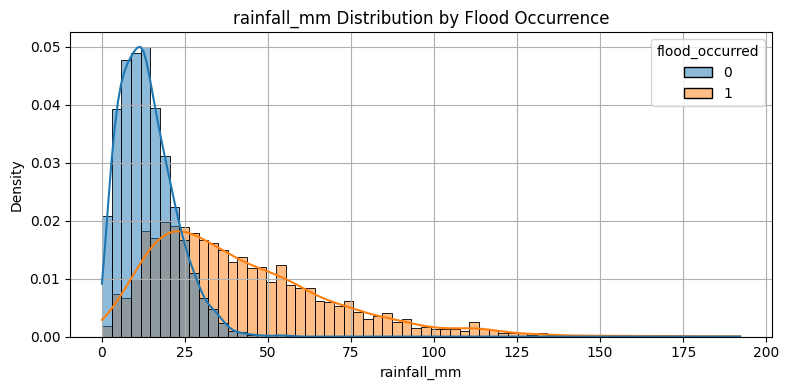

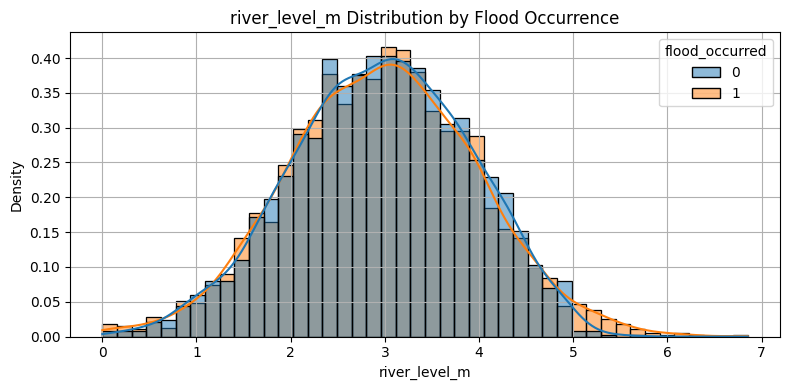

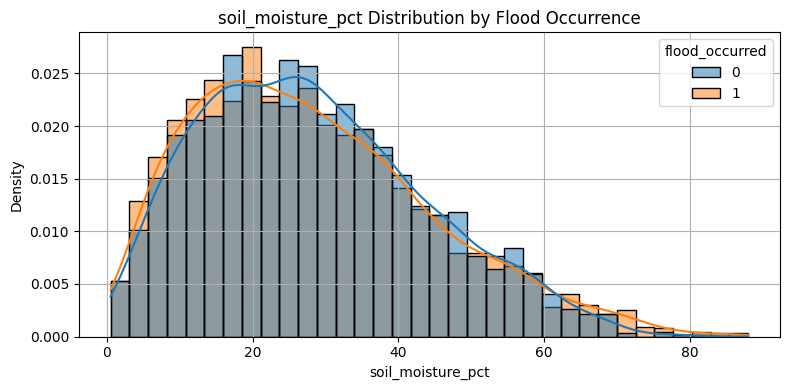

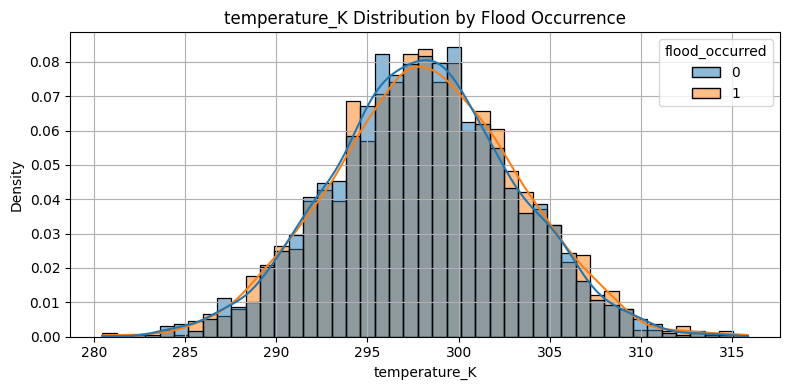

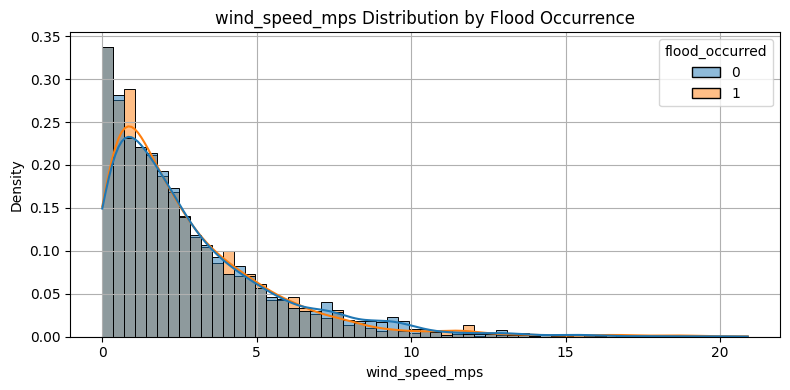

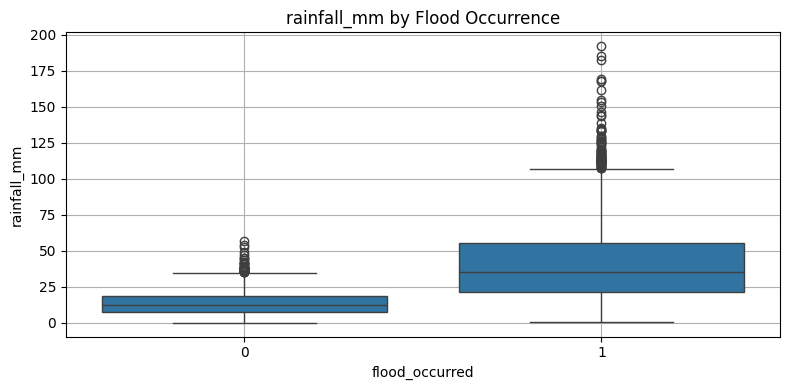

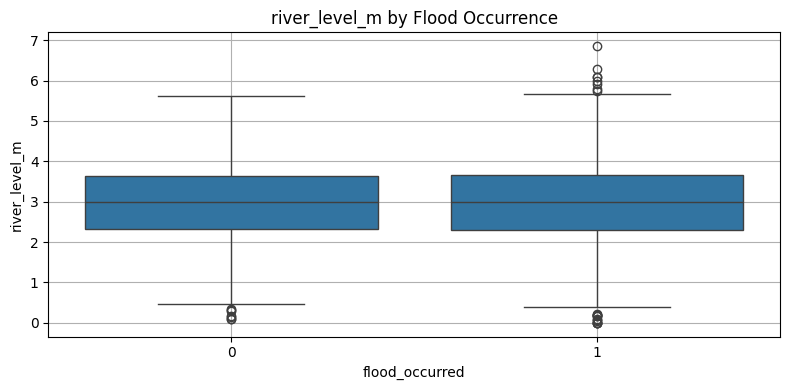

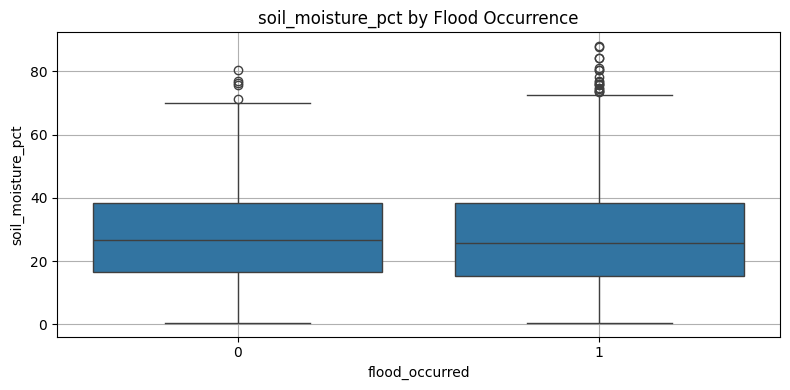

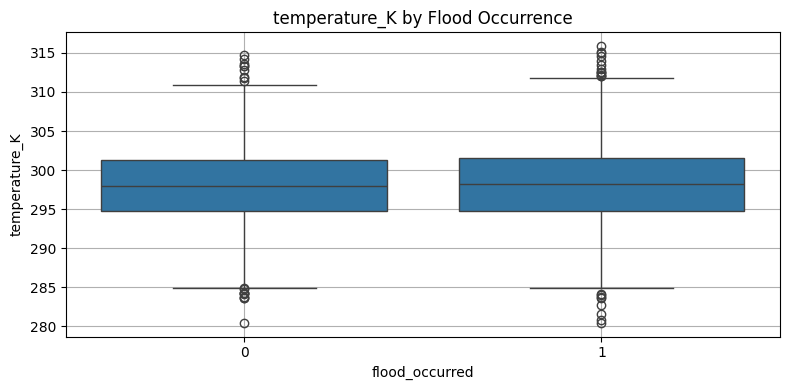

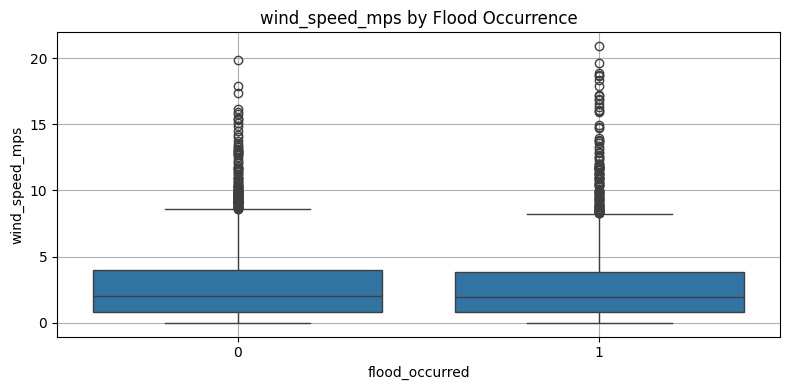

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Load your dataset
df = pd.read_csv("synthetic_flood_data.csv")

# ---- BASIC STATS ----
print("📊 Summary Statistics:\n", df.describe())
print("\n🔁 Skewness:\n", df.skew(numeric_only=True))
print("\n🎯 Kurtosis:\n", df.kurtosis(numeric_only=True))
print("\n⚖️ Class Balance:\n", df['flood_occurred'].value_counts(normalize=True))

# ---- CORRELATION HEATMAP ----
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# ---- DISTRIBUTIONS BY CLASS ----
features = df.columns.drop("flood_occurred")
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue="flood_occurred", kde=True, stat="density", common_norm=False)
    plt.title(f"{feature} Distribution by Flood Occurrence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- BOX PLOTS BY CLASS ----
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="flood_occurred", y=feature, data=df)
    plt.title(f"{feature} by Flood Occurrence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
